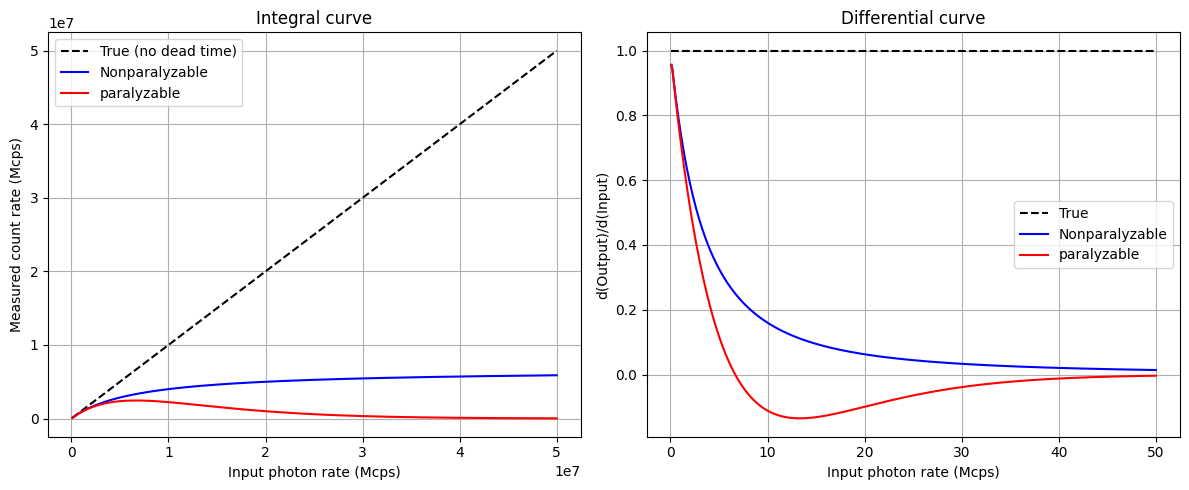

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 参数设置 ----------------
dead_time = 150e-9   # 死时间 100 ns
true_rate = np.linspace(1e5, 5e7, 500)  # 输入光子率 (photons/s)

# ---------------- 真实计数（无死时间） ----------------
counts_true = true_rate

# ---------------- 非瘫痪模式 (Nonparalyzable Model) ----------------
# 输出计数率公式: R_obs = R_true / (1 + R_true * τ)
counts_nonpar = true_rate / (1 + true_rate * dead_time)
counts_par = true_rate * np.exp(- true_rate * dead_time)

# ---------------- 微分曲线 ----------------
diff_true = np.gradient(counts_true, true_rate)
diff_nonpar = np.gradient(counts_nonpar, true_rate)
diff_par = np.gradient(counts_par, true_rate)

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 积分图 (计数率曲线)
plt.subplot(1,2,1)
plt.plot(true_rate, counts_true, 'k--', label="True (no dead time)")
plt.plot(true_rate, counts_nonpar, 'b', label="Nonparalyzable")
plt.plot(true_rate, counts_par, 'r', label="paralyzable")
plt.xlabel("Input photon rate (Mcps)")
plt.ylabel("Measured count rate (Mcps)")
plt.title("Integral curve")
plt.legend()
plt.grid(True)
 
# 微分图 (增益)
plt.subplot(1,2,2)
plt.plot(true_rate/1e6, diff_true, 'k--', label="True")
plt.plot(true_rate/1e6, diff_nonpar, 'b', label="Nonparalyzable")
plt.plot(true_rate/1e6, diff_par, 'r', label="paralyzable")
plt.xlabel("Input photon rate (Mcps)")
plt.ylabel("d(Output)/d(Input)")
plt.title("Differential curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


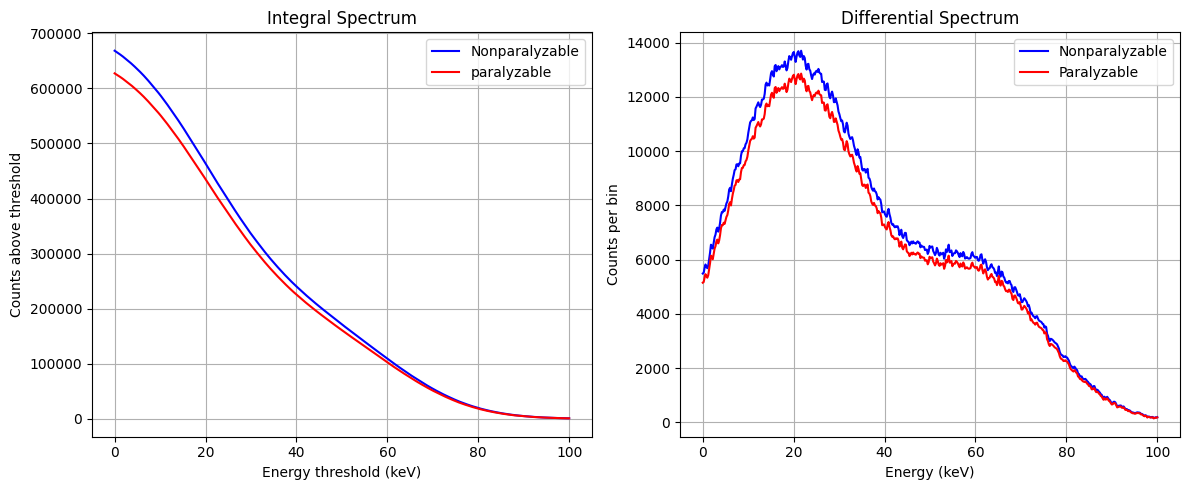

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------------- 参数 ----------------
n_photons = int(1e6)   # 模拟光子数
dead_time = 20e-9     # 死时间 200 ns  # 15ns
rate = 2e7             # 输入光子率 (cps)

# ---------------- 信号 + 噪声源 ----------------
# 信号：单能光子峰 60 keV, σ=2
signal = np.random.normal(60, 15, int(n_photons*0.3))

# 噪声：低能电子学噪声 5 keV, σ=1
noise = np.random.normal(20, 15, int(n_photons*0.7))

# 合并得到能量分布
events = np.concatenate([signal, noise])
events = events[events > 0]   # 去掉负能量

# ---------------- 积分谱计算函数 ----------------
def integral_spectrum(events, thresholds):
    spectrum = []
    for thr in thresholds:
        spectrum.append(np.sum(events > thr))
    return np.array(spectrum)

# ---------------- 阈值范围 ----------------
thresholds = np.linspace(0, 100, 500)

# ---------------- 理想探测器：无死时间 ----------------
integral_ideal = integral_spectrum(events, thresholds)

# ---------------- 非瘫痪探测器 ----------------
# 非瘫痪模型公式: R_obs = R_true / (1 + R_true * τ)
true_rate = rate
obs_rate = true_rate / (1 + true_rate * dead_time)
scaling = obs_rate / true_rate
integral_nonpar = integral_ideal * scaling


# ---------------- 瘫痪探测器 ----------------
# 非瘫痪模型公式: R_obs = R_true * exp(- R_true * τ)
true_rate = rate
obs_rate = true_rate * np.exp( - true_rate * dead_time)
scaling = obs_rate / true_rate
integral_par = integral_ideal * scaling



# ---------------- 微分谱 ----------------
diff_ideal = -np.gradient(integral_ideal, thresholds)
diff_nonpar = -np.gradient(integral_nonpar, thresholds)
diff_par = -np.gradient(integral_par, thresholds)

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 积分谱
plt.subplot(1,2,1)
# plt.plot(thresholds, integral_ideal, 'k', label="Ideal detector")
plt.plot(thresholds, integral_nonpar, 'b', label="Nonparalyzable")
plt.plot(thresholds, integral_par, 'r', label="paralyzable")
plt.xlabel("Energy threshold (keV)")
plt.ylabel("Counts above threshold")
plt.title("Integral Spectrum")
plt.legend()
plt.grid(True)

# 微分谱
plt.subplot(1,2,2)
# plt.plot(thresholds, diff_ideal, 'k', label="Ideal detector")
plt.plot(thresholds, diff_nonpar, 'b', label="Nonparalyzable")
plt.plot(thresholds, diff_par, 'r', label="Paralyzable")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Differential Spectrum")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


0.04


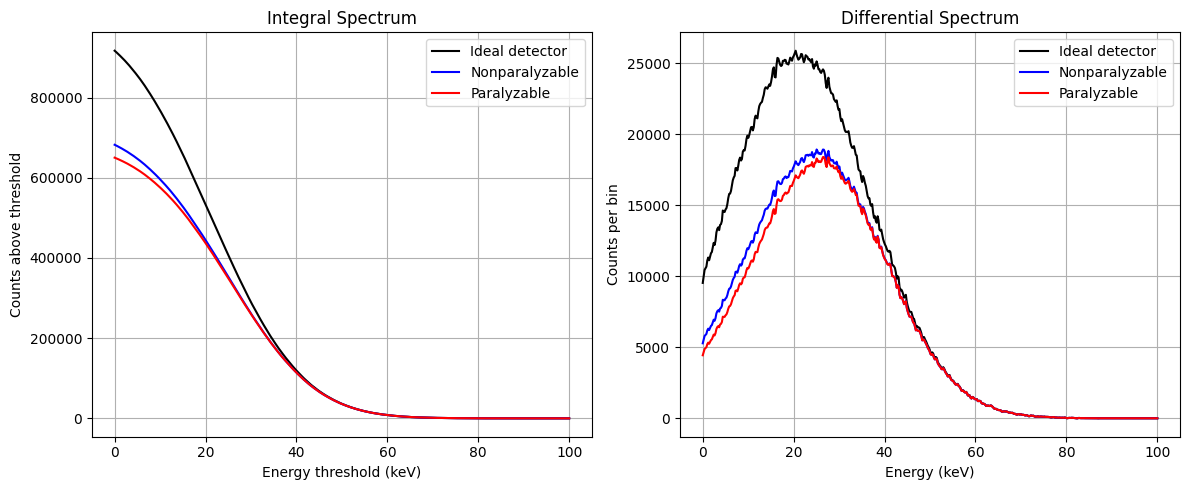

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 参数 ----------------
n_photons = int(1e6)   # 模拟光子数
integral_time = 400e-6 # 积分时间 400 us  （s）
dead_time = 15e-9     # 死时间 20 ns
rate = 2.5e7           # 最大输入光子率 (cps)

# n_photons = integral_time * rate

# ---------------- 信号 + 噪声源 ----------------

signal = np.random.normal(35, 15, int(n_photons*0.1))   # 信号峰
noise = np.random.normal(20, 15, int(n_photons*0.9))   # 噪声峰


# signal = np.random.normal(45, 5, int(n_photons*0.8))   # 信号峰
# noise  = np.random.normal(20, 5, int(n_photons*0.2))   # 噪声峰

events = np.concatenate([signal, noise])
events = events[events > 0]   # 去掉负能量

# ---------------- 采集时间 ----------------
T = n_photons / rate   # 等效采集时间 (s)
print(T)

# ---------------- 积分谱计算函数（考虑死时间） ----------------
def integral_spectrum(events, thresholds, tau, T, mode="ideal"):
    spectrum = []
    for thr in thresholds:
        # 阈值以上的光子数
        N_thr = np.sum(events > thr)
        # 输入光子率
        R_thr = N_thr / T       # 1/T = rate/n_photons 是单位光子数 计数率

        if mode == "ideal":
            R_obs = R_thr
        elif mode == "nonpar":
            R_obs = R_thr / (1 + R_thr * tau)
        elif mode == "par":
            R_obs = R_thr * np.exp(-R_thr * tau)
        else:
            raise ValueError("Unknown mode")

        # 转换回总计数数目
        spectrum.append(R_obs * T)
    return np.array(spectrum)

# ---------------- 阈值范围 ----------------
thresholds = np.linspace(0, 100, 500)

# ---------------- 三种模式的积分谱 ----------------
integral_ideal = integral_spectrum(events, thresholds, dead_time, T, mode="ideal")
integral_nonpar = integral_spectrum(events, thresholds, dead_time, T, mode="nonpar")
integral_par = integral_spectrum(events, thresholds, dead_time, T, mode="par")

# ---------------- 微分谱 ----------------
diff_ideal = -np.gradient(integral_ideal, thresholds)
diff_nonpar = -np.gradient(integral_nonpar, thresholds)
diff_par = -np.gradient(integral_par, thresholds)

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 积分谱
plt.subplot(1,2,1)
plt.plot(thresholds, integral_ideal, 'k', label="Ideal detector")
plt.plot(thresholds, integral_nonpar, 'b', label="Nonparalyzable")
plt.plot(thresholds, integral_par, 'r', label="Paralyzable")
plt.xlabel("Energy threshold (keV)")
plt.ylabel("Counts above threshold")
plt.title("Integral Spectrum")
plt.legend()
plt.grid(True)

# 微分谱
plt.subplot(1,2,2)
plt.plot(thresholds, diff_ideal, 'k', label="Ideal detector")
plt.plot(thresholds, diff_nonpar, 'b', label="Nonparalyzable")
plt.plot(thresholds, diff_par, 'r', label="Paralyzable")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Differential Spectrum")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
